In [1]:
from hyfluid import *

In [2]:
from dataloaders.dataloader_hyfluid import VideoInfos, CameraInfos, hyfluid_video_infos, hyfluid_camera_infos_list, \
    load_videos_data_device
from utils.utils_nerf import generate_rays_device, resample_images_torch

hyfluid_video_infos.root_dir = "../data/hyfluid"
device = torch.device("cuda")
dtype_device = torch.float16
train_video_data_device = load_videos_data_device(hyfluid_video_infos, dataset_type="train", device=device, dtype=dtype_device)
width, height = train_video_data_device.shape[3], train_video_data_device.shape[2]

# 2. load poses
train_indices = [0, 1, 2, 3]
train_poses_device = torch.tensor([hyfluid_camera_infos_list[i].transform_matrices for i in train_indices], device=device, dtype=dtype_device)  # (#cameras, 4, 4)

# 3. pre-sample rays
focals_device = torch.tensor([0.5 * width / torch.tan(0.5 * torch.tensor(hyfluid_camera_infos_list[i].camera_angle_x[0], dtype=dtype_device)) for i in train_indices], device=device, dtype=dtype_device)  # (#cameras)
rays_origin_device, rays_direction_device, u_device, v_device = generate_rays_device(train_poses_device, focals=focals_device, width=width, height=height, randomize=True)

# 4. resample images
train_video_resampled_device = resample_images_torch(train_video_data_device, u_device, v_device)  # (#videos, #frames, H, W, C)

In [3]:
print(f'train_video_data_device.shape: {train_video_data_device.shape}')

train_video_data_device.shape: torch.Size([4, 120, 1920, 1080, 3])


In [4]:
import matplotlib.pyplot as plt

# 选择相机索引和帧索引
camera_idx = 0  # 选择第0个相机
frame_idx = 10  # 选择第10帧

# 提取帧数据并转换到 CPU (如果在 CUDA 上)
frame1 = train_video_data_device[camera_idx, frame_idx].cpu().to(dtype=torch.float32).numpy()  # (1920, 1080, 3)
frame2 = train_video_resampled_device[camera_idx, frame_idx].cpu().to(dtype=torch.float32).numpy()  # (1920, 1080, 3)

# 归一化数据（如果数据是 0-255 范围，则转换为 0-1 ）
if frame1.max() > 1:
    frame1 = frame1 / 255.0
if frame2.max() > 1:
    frame2 = frame2 / 255.0

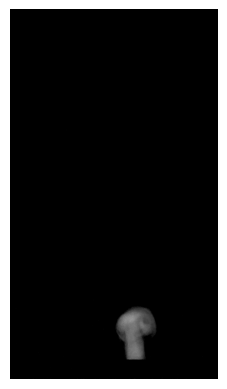

In [5]:
# 可视化
plt.imshow(frame1)
plt.axis("off")  # 隐藏坐标轴
plt.show()

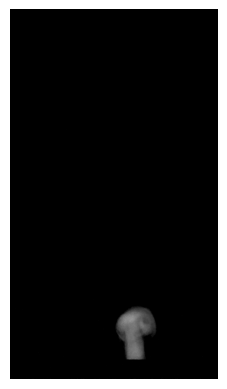

In [6]:
# 可视化
plt.imshow(frame2)
plt.axis("off")  # 隐藏坐标轴
plt.show()